### Problem Statement
Stock price prediction is the task of forecasting the future value of a given stock. Given the historical daily 
close price for S&P 500 Index, prepare and compare forecasting solutions.

S&P 500 or Standard and Poor's 500 index is an index comprising of 500 stocks from different sectors of 
US economy and is an indicator of US equities. Other such indices are the Dow 30, NIFTY 50, Nikkei 225, etc. 

In case of our stock price time series, we would like to model it as sequence where value at each 
time step is a function of previous values.  we would utilize the LSTMs to learn from the data and 
determine which past values to utilize for forecasting

- N (number of sequences): This will be set to 1 since we are dealing with only one 
stock’s price information.
- W (length of sequence): This will be set to total number of days worth of price 
information we have with us. Here we use the whole series as one big sequence.
- F (features per timestamp): This is again 1, as we are only dealing with closing stock 
value per timestamp.

In [15]:
%matplotlib inline

import math
import warnings
import numpy as np

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import mean_squared_error

import time
import pandas as pd
import pandas_datareader as pdr

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

### Define Functions

In [17]:
# get stock price information 
def get_raw_data(index_name,retry_attempts = 3):   
    if index_name:
        while retry_attempts > 0 :
            try:
                df = pdr.get_data_yahoo(index_name)
                new_df = df.reindex(index=pd.date_range(df.index.min(), 
                                          df.index.max(), 
                                          freq='D')).fillna(method='ffill')
                retry_attempts = 0
                return new_df
            except:
                print("Data pull failed. {} retry attempts remaining".\
                      format(retry_attempts))
                retry_attempts = retry_attempts - 1
    else:
        print("Invalid usage. Parameter index_name is required")
    return None
    

# prepare training and testing data sets for LSTM based sequence modeling
def get_seq_train_test(time_series, scaling=True,train_size=0.9):
    scaler = None
    if scaling:
        scaler = MinMaxScaler(feature_range=(0, 1))
        time_series = np.array(time_series).reshape(-1,1)
        scaled_stock_series = scaler.fit_transform(time_series)
    else:
        scaled_stock_series = time_series
        
    train_size = int(len(scaled_stock_series) * train_size)

    train = scaled_stock_series[0:train_size]
    test = scaled_stock_series[train_size:len(scaled_stock_series)]
    
    return train,test,scaler 



# Get stacked LSTM model for sequence modeling
# This function returns a single hidden layer RNN network with four LSTM units and a TimeDistributed 
# Dense output layer. We use mean squared error as our loss function
def get_seq_model(hidden_units=4,input_shape=(1,1),verbose=False):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*featuress

    model.add(LSTM(input_shape=input_shape, 
                   units = hidden_units, 
                   return_sequences=True
    ))
    
    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    model.add(TimeDistributed(Dense(1)))
    start = time.time()
    
    model.compile(loss="mse", optimizer="rmsprop")
    
    if verbose:
        print("> Compilation Time : ", time.time() - start)
        print(model.summary())
        
    return model



## Set Parameters

In [18]:
TRAIN_PERCENT = 0.7
STOCK_INDEX = '^GSPC'
VERBOSE=True

## Getting Data

<AxesSubplot:>

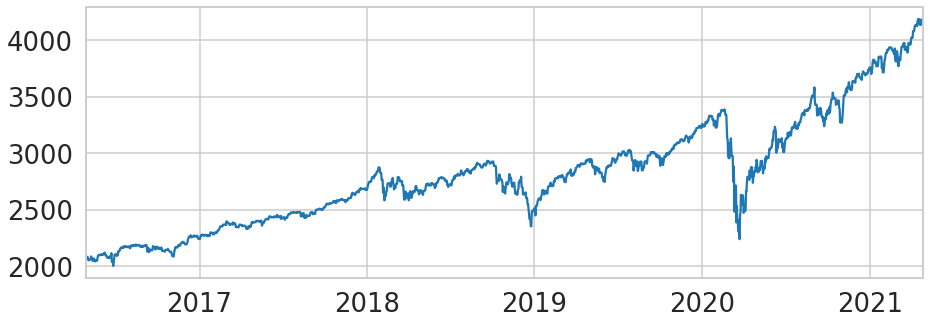

In [19]:
sp_df = get_raw_data(STOCK_INDEX)
sp_close_series = sp_df.Close 

sp_close_series.plot()

## Preprocessing Data

In [20]:
# split train and test datasets
train,test,scaler = get_seq_train_test(sp_close_series,
                                   scaling=True,
                                   train_size=TRAIN_PERCENT)

train = np.reshape(train,(1,train.shape[0],1))
test = np.reshape(test,(1,test.shape[0],1))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1276, 1)
train_y shape=(1, 1276, 1)
test_x shape=(1, 547, 1)
test_y shape=(1, 547, 1)


## Prepare LSTM Model

 get_seq_model function returns a single hidden layer RNN network with four LSTM units and a TimeDistributed 
 Dense output layer. We use mean squared error as our loss function

In [21]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],1),
                                                verbose=VERBOSE)   
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],1),
                                                verbose=VERBOSE)

> Compilation Time :  0.01096796989440918
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1276, 4)           96        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1276, 1)           5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


## Fit the Model

In [22]:
# train the model
seq_lstm_model.fit(train_x, train_y, 
               epochs=150, batch_size=1, 
               verbose=2)
print("Model Fit Complete")

Epoch 1/150
1/1 - 2s - loss: 0.0472
Epoch 2/150
1/1 - 0s - loss: 0.0408
Epoch 3/150
1/1 - 0s - loss: 0.0365
Epoch 4/150
1/1 - 0s - loss: 0.0332
Epoch 5/150
1/1 - 0s - loss: 0.0304
Epoch 6/150
1/1 - 0s - loss: 0.0281
Epoch 7/150
1/1 - 0s - loss: 0.0260
Epoch 8/150
1/1 - 0s - loss: 0.0241
Epoch 9/150
1/1 - 0s - loss: 0.0223
Epoch 10/150
1/1 - 0s - loss: 0.0208
Epoch 11/150
1/1 - 0s - loss: 0.0193
Epoch 12/150
1/1 - 0s - loss: 0.0180
Epoch 13/150
1/1 - 0s - loss: 0.0168
Epoch 14/150
1/1 - 0s - loss: 0.0156
Epoch 15/150
1/1 - 0s - loss: 0.0145
Epoch 16/150
1/1 - 0s - loss: 0.0136
Epoch 17/150
1/1 - 0s - loss: 0.0126
Epoch 18/150
1/1 - 0s - loss: 0.0118
Epoch 19/150
1/1 - 0s - loss: 0.0110
Epoch 20/150
1/1 - 0s - loss: 0.0103
Epoch 21/150
1/1 - 0s - loss: 0.0096
Epoch 22/150
1/1 - 0s - loss: 0.0090
Epoch 23/150
1/1 - 0s - loss: 0.0084
Epoch 24/150
1/1 - 0s - loss: 0.0079
Epoch 25/150
1/1 - 0s - loss: 0.0074
Epoch 26/150
1/1 - 0s - loss: 0.0069
Epoch 27/150
1/1 - 0s - loss: 0.0065
Epoch 28/1

## Train Prediction Performance

In [23]:
# train fit performance
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.01 RMSE


In [29]:
train_x.shape[1]

1276

## Test Prediction Performance
Since our test dataset is smaller (shape: (1,547,1)), we need some way to match the required shape(1,1276,1). 
While modeling sequences with RNNs, it is a common practice to pad sequences in order to match a given 
shape.

In [34]:
test_x.shape[1]

547

In [35]:
# Pad input sequence
testPredict = pad_sequences(test_x,
                                maxlen=train_x.shape[1],
                                padding='post',
                                dtype='float64')

testPredict.shape[1]

1276

In [37]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)

# evaluate performances
testScore = math.sqrt(mean_squared_error(test_y[0], 
                                         testPredict[0][:test_x.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.14 RMSE


## Plot Test Predictions

In [38]:
trainPredict.shape[1]

1

In [39]:
# inverse transformation
trainPredict = scaler.inverse_transform(trainPredict.\
                                        reshape(trainPredict.shape[1], -1))
testPredict = scaler.inverse_transform(testPredict.\
                                       reshape(testPredict.shape[1], -1))

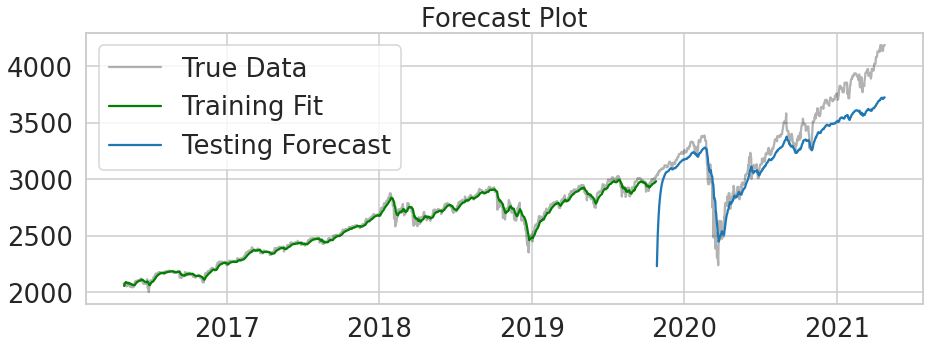

In [28]:
# plot the true and forecasted values
train_size = len(trainPredict)+1

plt.plot(sp_close_series.index,
         sp_close_series.values,c='black',
         alpha=0.3,label='True Data')
plt.plot(sp_close_series.index[1:train_size],
         trainPredict,label='Training Fit',c='g')
plt.plot(sp_close_series.index[train_size+1:],
         testPredict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
plt.show()

We can see that the training fit is nearly 
perfect which is kind of expected. The testing performance or the forecast also shows decent performance. 
Even though the forecast deviates from the actual at places, the overall performance both in terms of RMSE 
and the fit seemed to have worked